# Normal-tangential coordinates

Author: Jukka Aho

**Abstract**: Use of normal tangential coordinate system

In [1]:
using JuliaFEM.Core: Quad4, Seg2, Seg3, PlaneStressLinearElasticityProblem, DirichletProblem, update!, DirectSolver
typealias Node Vector{Float64}

Array{Float64,1}

In [2]:
using Gadfly
set_default_plot_size(10cm, 10cm)

Element normal definition in 2d

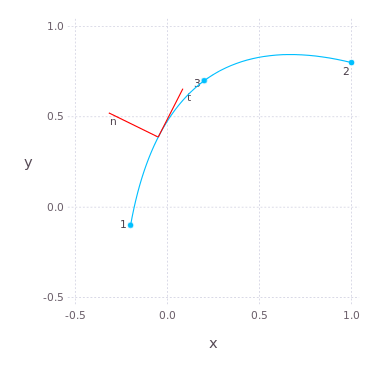

In [3]:
el = Seg3([1, 2, 3])
el["geometry"] = Node[[-0.2, -0.1], [1.0, 0.8], [0.2, 0.7]]
x = Float64[]
y = Float64[]
for xi in linspace(-1, 1)
    X = el("geometry", [xi], 0.0)
    push!(x, X[1])
    push!(y, X[2])
end
l1 = layer(x=x, y=y, Geom.line)

X1 = el("geometry", [-1.0], 0.0)
X2 = el("geometry", [1.0], 0.0)
X3 = el("geometry", [0.0], 0.0)
l2 = layer(x=[X1[1],X2[1],X3[1]], y=[X1[2],X2[2],X3[2]], label=["1","2","3"],
           Geom.point, Geom.label(;hide_overlaps=false))

xi = [-0.5]
X = el("geometry", xi, 0.0)
J = JuliaFEM.Core.get_jacobian(el, xi, 0.0)
t = vec(J)/norm(J)
n = [cos(pi/2) -sin(pi/2); sin(pi/2) cos(pi/2)]*t
a = 0.3
l3 = layer(x=[X[1], X[1]+a*t[1]], y=[X[2], X[2]+a*t[2]], label=["","t"],
           Geom.label(;hide_overlaps=false), Geom.line, Theme(default_color=colorant"red"))
l4 = layer(x=[X[1], X[1]+a*n[1]], y=[X[2], X[2]+a*n[2]], label=["","n"],
           Geom.label(;hide_overlaps=false), Geom.line, Theme(default_color=colorant"red"))

p = plot(l1, l2, l3, l4, Coord.Cartesian(xmin=-0.5, ymin=-0.5, xmax=1.0, ymax=1.0))

## Model defined in cartesian coordinates

Model defined using cartesian coordinates. In general set individual components of vector values using index number, 1=x, 2=y, 3=z.

In [4]:
geometry = Dict{Int64, Node}(
    1 => [0.0, 0.0],
    2 => [1.0, 0.0],
    3 => [1.0, 1.0],
    4 => [0.0, 1.0])
el1 = Quad4([1, 2, 3, 4])
el2 = Seg2([3, 4]) # load
el3 = Seg2([1, 2]) # symmetry 2
el4 = Seg2([4, 1]) # symmetry 1
update!([el1, el2, el3, el4], "geometry", geometry)
el1["youngs modulus"] = 900.0
el1["poissons ratio"] = 0.25
el2["displacement traction force 2"] = -100.0
el3["displacement 2"] = 0.0
el4["displacement 1"] = 0.0
problem = PlaneStressLinearElasticityProblem("block")
boundary = DirichletProblem("dirichlet boundary conditions", "displacement", 2)
push!(problem, el1, el2)
push!(boundary, el3, el4)
solver = DirectSolver("simple 2d block")
push!(solver, problem)
push!(solver, boundary)
solver.method = :UMFPACK
solver.nonlinear_problem = false
call(solver, 0.0)

INFO: Starting solver simple 2d block
INFO: # of field problems: 1
INFO: # of boundary problems: 1
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: block
INFO: dim = 8
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary conditions
INFO: Solving system
INFO: UMFPACK: solved in 0.2082831859588623 seconds. norm = 0.16197088596792505


(1,true)

INFO: timing info for iteration:
INFO: boundary assembly       : 0.1141359806060791
INFO: field assembly          : 1.1088120937347412
INFO: dump matrices to disk   : 1.1920928955078125e-6
INFO: solve problem           : 0.38747596740722656
INFO: update element data     : 0.030972003936767578
INFO: non-linear iteration    : 1.6414198875427246
INFO: solver finished in 1.7901818752288818 seconds.


In [5]:
using JuliaFEM.Test
@test isapprox(el1("displacement", [1.0, 1.0], 0.0), [1/36, -1/9])

Test Passed
  Expression: isapprox(el1("displacement",[1.0,1.0],0.0),[1 / 36,-1 / 9])

In [6]:
norm(el1("displacement", [1.0, 1.0], 0.0))

0.11453071182271282

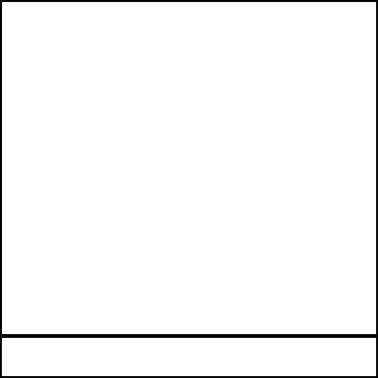

In [7]:
using Compose

X = el1("geometry")
u = el1("displacement", 0.0)
x = X+u

root = context()
p1 = polygon([tuple(X[i][1], X[i][2]) for i=1:4])
p2 = polygon([tuple(x[i][1], x[i][2]) for i=1:4])
undeformed = compose(root, p1, linewidth(1mm), fill(nothing), stroke("black"))
deformed = compose(root, p2, linewidth(1mm), fill(nothing), stroke("black"))
compose(undeformed, deformed)

## Using normal tangential coordinates

Sometimes it's more convenient to set boundary conditions using normal-tangential coordinates.

In [7]:
rot(ϕ) = [cos(ϕ) -sin(ϕ); sin(ϕ) cos(ϕ)]

rot (generic function with 1 method)

In [9]:
using JuliaFEM.Core: Quad4, Seg2, Seg3, PlaneStressLinearElasticityProblem, DirichletProblem, update!, DirectSolver
typealias Node Vector{Float64}
using JuliaFEM.Core: calculate_normal_tangential_coordinates!

# 2d rotation matrix
#ϕ = -pi/4
ϕ = 0
rmat(ϕ) = [cos(ϕ) -sin(ϕ); sin(ϕ) cos(ϕ)]

geometry = Dict{Int64, Node}(
    1 => rmat*[0.0, 0.0],
    2 => rmat*[1.0, 0.0],
    3 => rmat*[1.0, 1.0],
    4 => rmat*[0.0, 1.0])
el1 = Quad4([1, 2, 3, 4])
el2 = Seg2([3, 4]) # load
el3 = Seg2([1, 2]) # symmetry 2
el4 = Seg2([4, 1]) # symmetry 1
update!([el1, el2, el3, el4], "geometry", geometry)
calculate_normal_tangential_coordinates!([el2, el3, el4], 0.0)

el1["youngs modulus"] = 900.0
el1["poissons ratio"] = 0.25
# traction force in normal direction, (i.e. pressure load)
el2["displacement traction force N"] = 100.0
# support sides in normal direction
el3["displacement 2"] = 0.0
el4["displacement 1"] = 0.0
problem = PlaneStressLinearElasticityProblem("block")
boundary = DirichletProblem("dirichlet boundary conditions", "displacement", 2)
push!(problem, el1, el2)
push!(boundary, el3, el4)
solver = DirectSolver("rotated 2d block")
push!(solver, problem)
push!(solver, boundary)
solver.method = :UMFPACK
solver.nonlinear_problem = false
call(solver, 0.0)

LoadError: LoadError: MethodError: `*` has no method matching *(::Function, ::Array{Float64,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
  *{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},S}(!Matched::Union{DenseArray{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},2},SubArray{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},2,A<:DenseArray{T,N},I<:Tuple{Vararg{Union{Colon,Int64,Range{Int64}}}},LD}}, ::Union{DenseArray{S,1},SubArray{S,1,A<:DenseArray{T,N},I<:Tuple{Vararg{Union{Colon,Int64,Range{Int64}}}},LD}})
  *{TA,TB}(!Matched::Base.LinAlg.AbstractTriangular{TA,S<:AbstractArray{T,2}}, ::Union{DenseArray{TB,1},DenseArray{TB,2},SubArray{TB,1,A<:DenseArray{T,N},I<:Tuple{Vararg{Union{Colon,Int64,Range{Int64}}}},LD},SubArray{TB,2,A<:DenseArray{T,N},I<:Tuple{Vararg{Union{Colon,Int64,Range{Int64}}}},LD}})
  ...
while loading In[9], in expression starting on line 10

In [5]:
full(JuliaFEM.Core.assemble(boundary, 0.0).stiffness_matrix)

7x7 Array{Float64,2}:
 0.333333  0.0       0.0  0.0       0.0  0.0  0.166667
 0.0       0.333333  0.0  0.166667  0.0  0.0  0.0     
 0.0       0.0       0.0  0.0       0.0  0.0  0.0     
 0.0       0.166667  0.0  0.333333  0.0  0.0  0.0     
 0.0       0.0       0.0  0.0       0.0  0.0  0.0     
 0.0       0.0       0.0  0.0       0.0  0.0  0.0     
 0.166667  0.0       0.0  0.0       0.0  0.0  0.333333

In [6]:
K = sparse(JuliaFEM.Core.assemble(problem, 0.0).stiffness_matrix)
f = sparse(JuliaFEM.Core.assemble(problem, 0.0).force_vector)

8x1 sparse matrix with 2 Float64 entries:
	[6, 1]  =  -50.0
	[8, 1]  =  -50.0

In [264]:
# normal version
m = 1/6*[2 1; 1 2]*6
C1 = spzeros(8, 8)
C1[[1,3],[1,3]] += m
C1[[2,4],[2,4]] += m
C1[[1,7],[1,7]] += m
C1[[2,8],[2,8]] += m

D = spzeros(8, 8)
C2 = spzeros(8, 8)
C2[[1,3],[1,3]] += m
C2[[2,4],[2,4]] += m
C2[[1,7],[1,7]] += m
C2[[2,8],[2,8]] += m

#C1[:, [3,4]] = (rot(pi/2)'*C1[:, [3,4]]')'
#C2[:, [3,4]] = (rot(pi/2)'*C2[:, [3,4]]')'
#C1[[3,4], :] = rot(pi/2)'*C1[[3,4], :]
#C2[[3,4], :] = rot(pi/2)'*C2[[3,4], :]

# eliminate tangential constraint
C1[:, 3] = 0
C2[:, 3] = 0
#C1[3, :] = 0
#C2[3, :] = 0

C1[:, 8] = 0
C2[:, 8] = 0
#C1[8, :] = 0
#C2[8, :] = 0

dump(round(full(C1), 3))
dump(round(full(C2), 3))
dump(round(full(D), 3))

Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 4.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  4.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 4.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  4.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  

In [371]:
# biorthogonal version
m = [1 0; 0 1]
#m = 1/6*[2 1; 1 2]
C1 = spzeros(8, 8)
C1[[1,3],[1,3]] += m
C1[[2,4],[2,4]] += m
C1[[1,7],[1,7]] += m
C1[[2,8],[2,8]] += m

C1[[3,5],[3,5]] += m
C1[[4,6],[4,6]] += m
C1[[7,5],[7,5]] += m
C1[[8,6],[8,6]] += m

D = spzeros(8, 8)
C2 = spzeros(8, 8)
#C2[[1,3],[1,3]] += m
#C2[[2,4],[2,4]] += m
#C2[[1,7],[1,7]] += m
#C2[[2,8],[2,8]] += m
#C2[[3,4],:] = rot(pi/2)*C2[[3,4],:]

# working
#=
C2[1, 1] = 1.0
C2[2, 2] = 1.0
D[3, 3] = 1.0
C2[4, 4] = 1.0
C2[7, 7] = 1.0
D[8, 8] = 1.0
=#

tangents = Vector{Float64}[
    [1.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0]]

normals = Vector{Float64}[rot(pi/2)*t for t in tangents]

#t1 = [1, 0]
#n1 = rot(pi/2)*t1
# both N and T fixed
C2[1, [1,2]] = normals[1]
C2[2, [1,2]] = tangents[1]

#t2 = [1, 0]
#n2 = rot(pi/2)*t2
# normal direction fixed, tangential allowed to move
C2[3, [3,4]] = normals[2]
D[4, [3,4]] = tangents[2]
#C1[4, :] = 0

#t3 = [0, 1]
#n3 = rot(pi/2)*t3
# allowed to move in n and t directions
#D[5, [5,6]] = normals[3]
#D[6, [5,6]] = tangents[3]
D[5,5] = 1.0
D[6,6] = 1.0

#t4 = [0, -1]
#n4 = rot(pi/2)*t4
# normal fixed, tangential free
C2[7, [7,8]] = normals[4]
D[8, [7,8]] = tangents[4]
#C2[6, :] = 0

#D[4,:] = 0
#D[8,:] = 0
#C1[4,:] = 0
#C1[:,4] = 0
#C1[8,:] = 0
#C1[:,8] = 0


dump(round(full(C1), 3))
dump(round(full(C2), 3))
dump(round(full(D), 3))

Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  -1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0
Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.

In [372]:
g = spzeros(8, 1)
A = [K C1'; C2 D]
b = [f; g; h]

info("size of A = $(size(A))")
E = spzeros(2, 16)
E[2,16] = 1.0
h = spzeros(2, 1)
#A = [A E'; E spzeros(2,2)]
#b = [b; h]
#full(A)

ENV["COLUMNS"] = 300

dim = size(A, 1)
info("total dim = $dim")

nz1 = sort(unique(rowvals(A)))
nz2 = sort(unique(rowvals(A')))
A = A[nz1, nz2]
b = b[nz1]
u = zeros(dim)
T = full(A)
T[abs(T) .< 1.0e-9] = 0
info("solving")
sol = T \ full(b)
info("solved")

u[nz1] = sol
u[abs(u).<1.0e-9] = 0.0
u = reshape(full(u), 2, round(Int, length(u)/2))
full(u)

INFO: size of A = (16,16)
INFO: total dim = 16


2x8 Array{Float64,2}:
 0.0  0.0277778   0.0277778   0.0         0.0    0.0  0.0  0.0
 0.0  0.0        -0.111111   -0.111111  -25.0  -25.0  0.0  0.0

INFO: solving
INFO: solved


In [373]:
u[:,3]

2-element Array{Float64,1}:
  0.0277778
 -0.111111 

In [374]:
u_tip = el1("displacement", [1.0, 1.0], 0.0)
info("displacement on tip: $u_tip, magnitude = $(norm(u_tip))")

INFO: displacement on tip: [0.027777777777777783,-0.11111111111111115], magnitude = 0.11453071182271282


In [375]:
using JuliaFEM.Test
@test isapprox(norm(u_tip), norm([1/36, -1/9]))

Test Passed
  Expression: isapprox(norm(u_tip),norm([1 / 36,-1 / 9]))

In [376]:
round(Int, T)

16x16 Array{Int64,2}:
  440   150  -260   -30  -220  -150    40    30  2  0  0  0  0  0  0  0
  150   440    30    40  -150  -220   -30  -260  0  2  0  0  0  0  0  0
 -260    30   440  -150    40   -30  -220   150  0  0  2  0  0  0  0  0
  -30    40  -150   440    30  -260   150  -220  0  0  0  2  0  0  0  0
 -220  -150    40    30   440   150  -260   -30  0  0  0  0  2  0  0  0
 -150  -220   -30  -260   150   440    30    40  0  0  0  0  0  2  0  0
   40   -30  -220   150  -260    30   440  -150  0  0  0  0  0  0  2  0
   30  -260   150  -220   -30    40  -150   440  0  0  0  0  0  0  0  2
    0     1     0     0     0     0     0     0  0  0  0  0  0  0  0  0
    1     0     0     0     0     0     0     0  0  0  0  0  0  0  0  0
    0     0     0     1     0     0     0     0  0  0  0  0  0  0  0  0
    0     0     0     0     0     0     0     0  0  0  1  0  0  0  0  0
    0     0     0     0     0     0     0     0  0  0  0  0  1  0  0  0
    0     0     0     0     0     0     0 